In [2]:
#Image segmentation with cats and dogs. Doing semantic segmentation rather instance segmentation.
#Collect new dataset

#!wget http:/ /www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!wget http:/ /www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
#!tar -xf images.tar.gz
#!tar -xf annotations.tar.gz

# importing the "tarfile" module
import tarfile

# open file
file = tarfile.open('C:/Users/joshu/Documents/TensorFlow Learning Materials/Advanced Computer Vision/annotations.tar.gz')

# extracting file
file.extractall('C:/Users/joshu/Documents/TensorFlow Learning Materials/Advanced Computer Vision')

file.close()


In [3]:
file = tarfile.open('C:/Users/joshu/Documents/TensorFlow Learning Materials/Advanced Computer Vision/images.tar.gz')

file.extractall('C:/Users/joshu/Documents/TensorFlow Learning Materials/Advanced Computer Vision')

file.close()

In [5]:
import os
  
input_dir = "C:/Users/joshu/Documents/TensorFlow Learning Materials/Advanced Computer Vision/images" 
target_dir = "C:/Users/joshu/Documents/TensorFlow Learning Materials/Advanced Computer Vision/annotations/trimaps" 
  
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

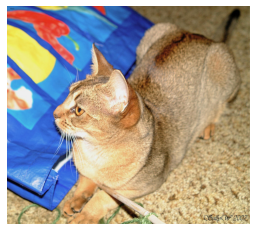

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

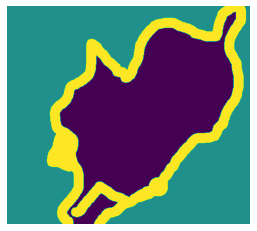

In [7]:
#Show images corresponding target
def display_target(target_array):
    #Original labels range from 1,2,3. Subtract 1 so its 0 - 2. Multiply so labels become
    #0 black, 127 gray, and 254 near white
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode = "grayscale"))
display_target(img)

In [14]:
import numpy as np
import random

#Resize everything
img_size = (200, 200)
#get total number of samples in the data
num_imgs = len(input_img_paths)

#Seed and shuffle the images/targets
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size = img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size = img_size, color_mode = "grayscale"))
    #make labels become 0,1,2
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = "float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype = "uint8")
#Load all images and their targets
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

#Reserve for validation
num_val_samples = 1000
#Split for train/test
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [15]:
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
  
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = preprocessing.Rescaling(1./255)(inputs)                                     
    
    #padding = "same" is to avoid the influence of border padding on feature map size
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    #We use strides on everyother because we care about the spatial location of information in the image
    #This downsamples feature maps while retaining location information
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
  
    #To this point the image has been downsampled to (25,25, 256) we use these layers to upsample back
    #to the original shape of (200, 200, 3) these layers learn to upsample
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        64, 3, activation="relu", padding="same", strides=2)(x)
  
    outputs = layers.Conv2D(num_classes, 3, activation="softmax",            
     padding="same")(x)                                                      
 
    model = keras.Model(inputs, outputs)
    return model
  
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 256)       2951

In [20]:
#I don't think there is enough memory on my laptop to run this right now...
model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only = True)]

history = model.fit(train_input_imgs, train_targets, epochs = 50,
                   callbacks = callbacks, batch_size = 64,
                   validation_data = (val_input_imgs, val_targets))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:
#It should start overfitting midway through
from tensorflow.keras.utils import array_to_img
  
model = keras.models.load_model("oxford_segmentation.keras")
  
i = 4 
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
  
mask = model.predict(np.expand_dims(test_image, 0))[0]

#displays a models prediction
def display_mask(pred):          
    mask = np.argmax(pred, axis=-1)
    mask *= 127 
    plt.axis("off")
    plt.imshow(mask)
  
display_mask(mask)

## Network Architecture

In [21]:
#Example of residual connection when number of filters change
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
#Where residual connection is made. Increase # of output filers from 32 to 64
#padding = same to avoid downsampling due to padding
x = layers.Conv2D(64, 3, activation="relu", padding = "same")(x)
#residual only had 32 filters so a 1 x 1 conv2d is used to project to right shape
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

In [22]:
#Example of residual connection where target block includes a max pooling layer
inputs = keras.Input(shape = (32, 32, 3))
x = layers.Conv2D(32, 3, activation = "relu")(inputs)
residuals = x
#Block of two layers where residual connection is created. includes 2 x 2 max pooling layer
#Same is used in conv2d and max pool to avoid downsampling.
x = layers.Conv2D(64, 3, activation = "relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
#use strides here to match the downsampling created by max pooling layer
residual = layers.Conv2D(64, 1, strides = 2)(residual)
x = layers.add([x, residual])

In [ ]:
#Batch normalization -- activation comes last
x = layers.Conv2D(32, 3, use_bias = False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#batch normalization will center your inputs on zero, while your relu
#activation uses zero as a pivot for keeping or dropping activated channels: 
#doing normalization before the activation maximizes the utilization of the relu
#ordering can be changed so normalization occurs after activation with little change to result
#Matter of preference

In [24]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.2)
])

In [26]:
#Bring everything together for this section. Mini Xception model
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)

x = preprocessing.Rescaling(1./255)(x)
#Note that the assumption that underlies separable convolution, “feature channels are largely independent,” does not hold
#for RGB images! Red, green, and blue color channels are actually highly correlated in natural images. As such, the 
#first layer in our model is a regular Conv2D layer. We’ll start using SeparableConv2D afterwards.
x = layers.Conv2D(filters = 32, kernel_size = 5, use_bias = False)(x)

#Apply series of convolution blocks with increasing feature depth 
for size in [32,64,128,256,512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding = "same", use_bias = False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding = "same", use_bias = False)(x)
    
    x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)
    
    residual = layers.Conv2D(size, 1, strides = 2, padding = "same", use_bias = False)(residual)
    
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)

## Visualizing What Convnets Learn

### Visualizing Intermeditate Activations

In [28]:
#I know I misspelled it. Too lazy to fix it. 
model = keras.models.load_model("convnet_from_scratch_with_augmentatin.keras")
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x000001D9965444C0>>

In [29]:
img_path = keras.utils.get_file(fname = "cat.jpg", origin = "https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size = target_size)
    #Turn image into an array of shape (180,180,3)
    array = keras.utils.img_to_array(img)
    #Add a dimension to transform the array into a "batch" of a single sample
    #Shape = (1,180,180,3)
    array = np.expand_dims(array, axis=0)
    return array
img_tensor = get_img_array(img_path, target_size = (180,180))

81920/80329 [==============================] - 0s 0us/step


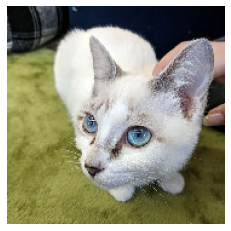

In [30]:
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [31]:
layer_outputs = []
layer_names = []
#Extract outputs of all Conv2D and max pooling 2d layers
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        #Save names
        layer_names.append(layer.name)
#return these outputs given the input
activation_model = keras.Model(inputs = model.input, outputs=layer_outputs)

In [32]:
#Returns list of 9 numpy arrays: one array per layer activation. 
activations = activation_model.predict(img_tensor)

In [33]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


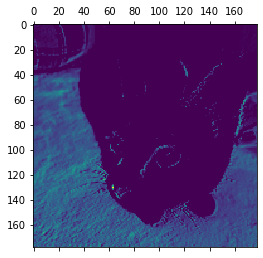

In [34]:
#plot the fifth channel of the activation of the first layer 
plt.matshow(first_layer_activation[0,:,:,5], cmap="viridis")

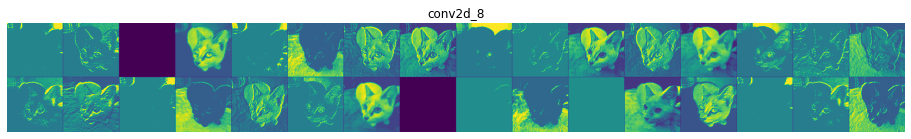

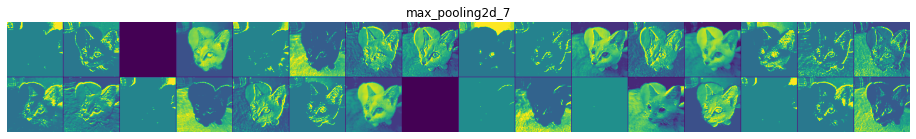

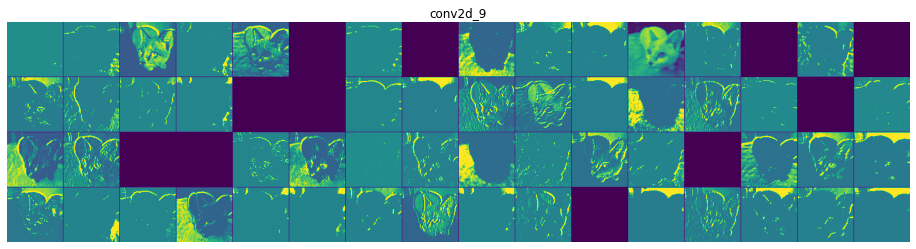

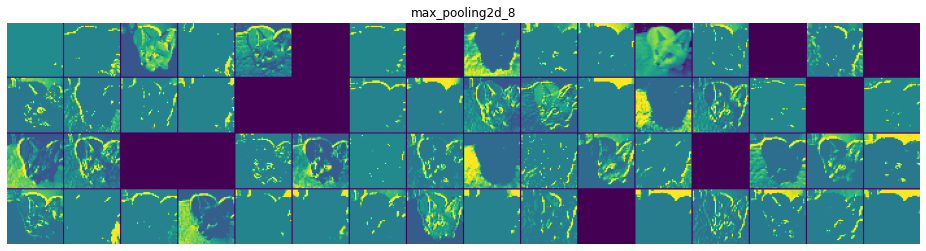

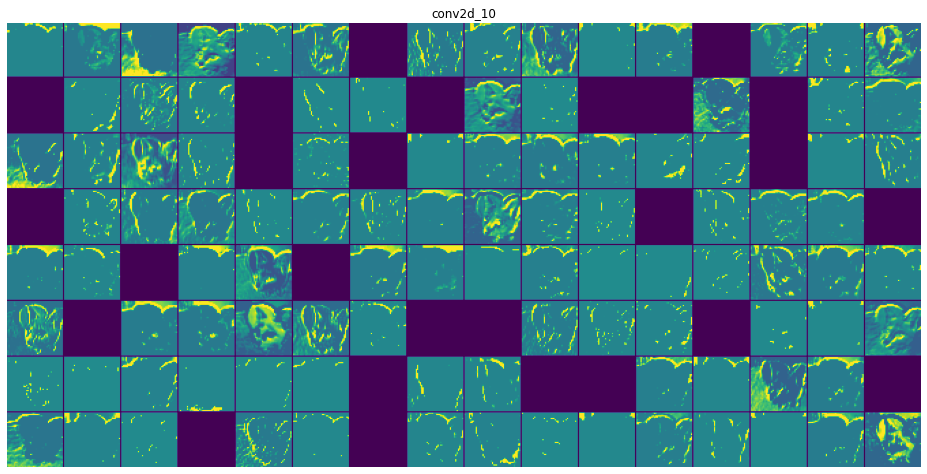

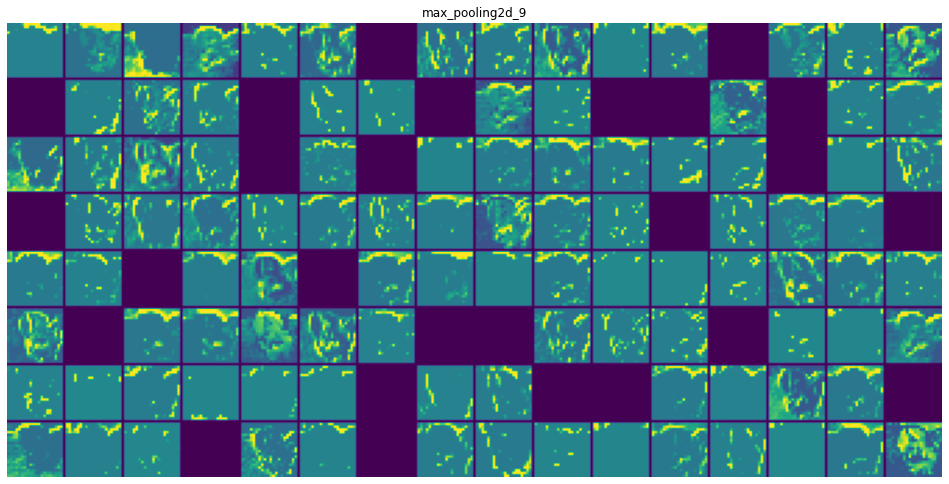

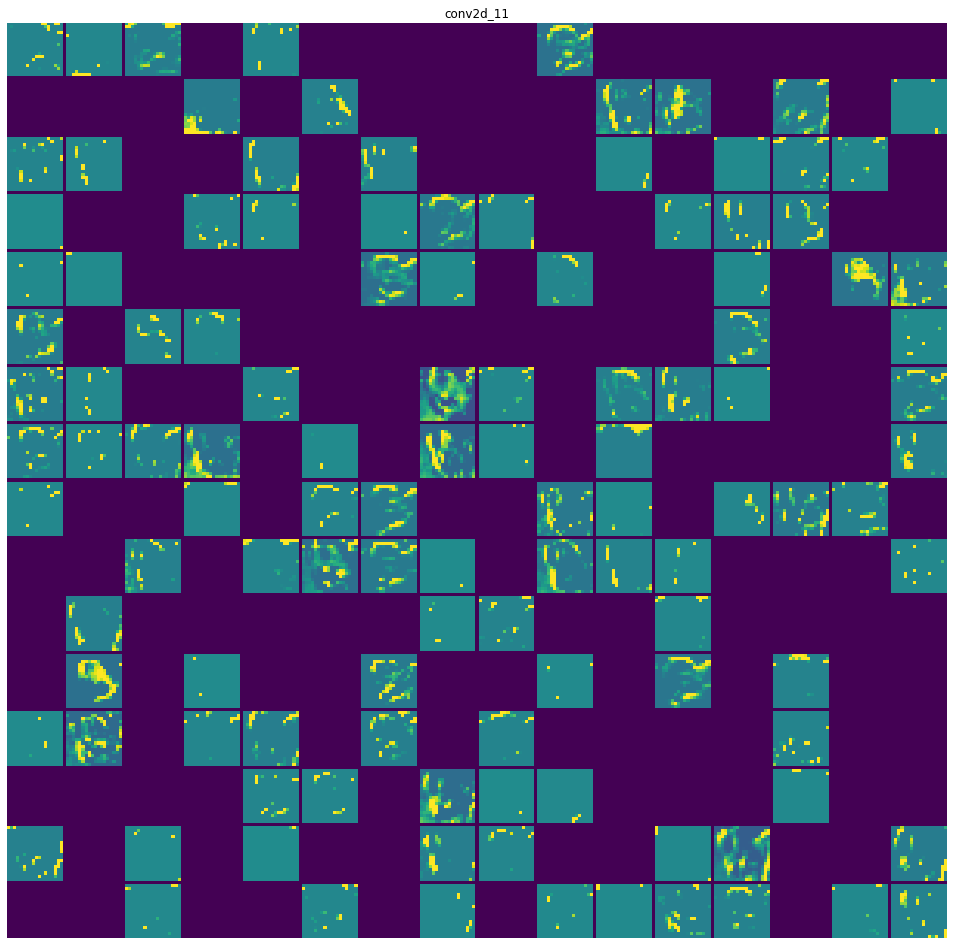

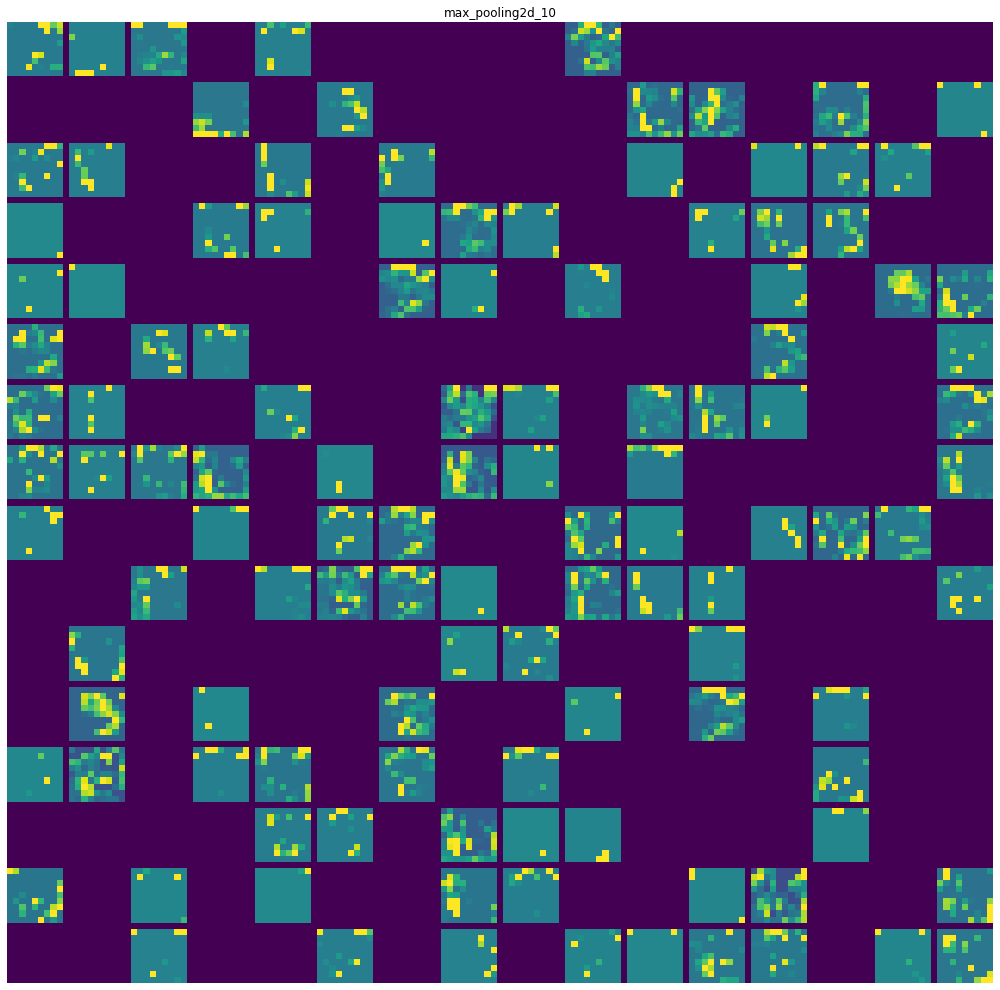

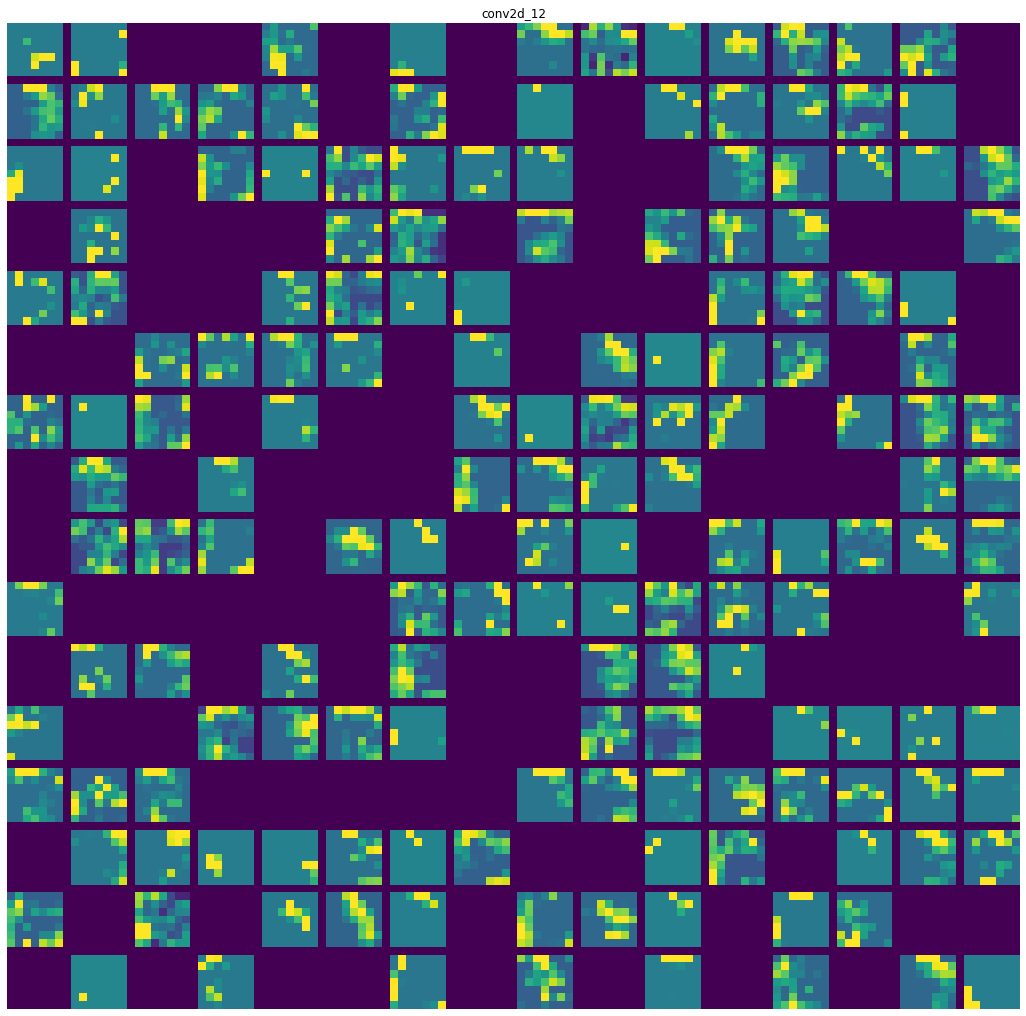

In [35]:
#Plot complete visualization of all activations in the network
images_per_row = 16 
#Iterate over the activations and names of layers
for layer_name, layer_activation in zip(layer_names, activations):
    #layer activation has shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]                                
    size = layer_activation.shape[1]                                       
    n_cols = n_features // images_per_row
    #prep an empty grid for displaying all channels in this activation
    display_grid = np.zeros(((size + 1) * n_cols - 1,                      
                             images_per_row * (size + 1) - 1))  
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            #single channel or feature
            channel_image = layer_activation[0, :, :, channel_index].copy()
            #Normalize channel values
            if channel_image.sum() != 0:                                   
                channel_image -= channel_image.mean()                      
                channel_image /= channel_image.std()                       
                channel_image *= 64                                        
                channel_image += 128                                       
            channel_image = np.clip(channel_image, 0, 255).astype("uint8") 
            #Place matrix in empty grid that was made
            display_grid[
                col * (size + 1): (col + 1) * size + col,                  
                row * (size + 1) : (row + 1) * size + row] = channel_image 
    scale = 1. / size          
    #Display
    plt.figure(figsize=(scale * display_grid.shape[1],                     
                        scale * display_grid.shape[0]))                    
    plt.title(layer_name)                                                  
    plt.grid(False)                                                        
    plt.axis("off")                                                        
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.

As you go deeper, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Deeper presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.

The sparsity of the activations increases with the depth of the layer: in the first layer, almost all filters are activated by the input image, but in the following layers, more and more filters are blank. This means the pattern encoded by the filter isn’t found in the input image.

## Visualizing Convnet Filters

In [36]:
#Create Xception model
model = keras.applications.xception.Xception(weights="imagenet", include_top=False)

83689472/83683744 [==============================] - 4s 0us/step


In [37]:
#Print names of all convolutial layers in Xception
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_26
block3_sepconv1
block3_sepconv2
conv2d_27
block4_sepconv1
block4_sepconv2
conv2d_28
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_29
block14_sepconv1
block14_sepconv2


In [39]:
#Create second model that outputs a specific layer - a feature extractor model 
layer_name = "block3_sepconv1"
layer = model.get_layer(name = layer_name)
#use model.input and layer.output to create a model that, given an input image, returns the output of a target layer
feature_extractor = keras.Model(inputs = model.input, outputs = layer.output)

In [40]:
#Feature extractor 
activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

In [41]:
#define a function that returns a scalar quantifying how a given input image "activates" a given filter in the layer
#This is the "loss function" that gets maxmixized during gradient ascent

#Take in an image tensor and index of the filter being considered
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    #Avoids border artifacts by only involving non-border pixels in the loss
    #first two pixels along the sides of the activation
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    #return the mean of the activation values for the filter
    return tf.reduce_mean(filter_activation)

In [43]:
#use model(x) instead of predict(x) to retrieve the gradient because predict is not differentiable
#loss maximization via stochastic gradient ascent

import tensorflow as tf

#speeds up the function
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        #watch the tensor image since its not a variable (it doesnt get watched automatically)
        tape.watch(image)
        #compute the loss scalar - how much current image activate the filter
        loss = compute_loss(image, filter_index)
    #compute the gradient of the loss with respect to the image
    grads = tape.gradient(loss, image)
    #normalize gradient using L2 norm - makes update magnitude be in same range
    grads = tf.math.l2_normalize(grads)
    #move the image a little bit in a direction that activates the target filter more strongly
    image += learning_rate * grads
    return image

In [44]:
#generate filter visualizations 

img_width = 200 
img_height = 200 
  
def generate_filter_pattern(filter_index):
    #number of gradient ascent steps to apply
    iterations = 30        
    #amplitude of a single step
    learning_rate = 10.                                                   
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        #initialize an image tensor with random values
        shape=(1, img_width, img_height, 3))  
    #repeatedly update the values of the image tensor so as to maximize loss function
    for i in range(iterations):                                           
        image = gradient_ascent_step(image, filter_index, learning_rate)  
    return image[0].numpy()
#results in an image tensor with shape(200,200,3) with values that may not be integers w/in [0,255]

In [48]:
#Utility function to convert a tensor into a valid image
def deprocess_image(image):
    #normalize values w/in [0,255] range
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    #center crop to avoid border artifacts
    image = image[25:-25,25:-25, :]
    return image

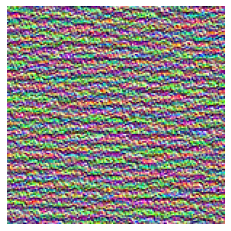

In [49]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

### Pattern that the second channel in layer block3_sepconv1 responds to maximally. Mostly responds to horizontal pattern.

In [60]:
#Generate a grid of all filter response patterns in a layer
#all_images = []                             
#for filter_index in range(64):
#    print(f"Processing filter {filter_index}")
#    image = deprocess_image(
#        generate_filter_pattern(filter_index)
#    )
#    all_images.append(image)
#Create a blank canvas for the filter visualizations
#margin = 5                                  
#n = 8 
#cropped_width = img_width - 25 * 2 
#cropped_height = img_height - 25 * 2 
#width = n * cropped_width + (n - 1) * margin
#height = n * cropped_height + (n - 1) * margin
#stitched_filters = np.zeros((width, height, 3))

In [59]:
#This is not working not sure why!

#for i in range(n):
#    for j in range(n):
#        image = all_images[i * n + j]
#        stitched_filters[
#            row_start = (cropped_width + margin) * i
#            row_end = (cropped_width + margin) * i + cropped_width
#            column_start = (cropped_height + margin) * j
#            column_end = (cropped_height + margin) * j + cropped_height
        
#            stitched_filters[
#                row_start: row_end,
#                column_start: column_end, :] = image
  
#keras.utils.save_img(                       
#    f"filters_for_layer_{layer_name}.png", stitched_filters)

## Visualizing Heatmaps of Class Activation

In [61]:
model = keras.applications.xception.Xception(weights = "imagenet")

91889664/91884032 [==============================] - 4s 0us/step


In [62]:
#Preprocess an input image for the Xception model
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")    
 
def get_img_array(img_path, target_size):
    #return an image of size 299x299
    img = keras.utils.load_img(img_path, target_size=target_size)   
    #array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    #add dimension to transform the array into batch size (1, 299,299, 3)
    array = np.expand_dims(array, axis=0)           
    #Preprocess batch (does channel wise color normalization)
    array = keras.applications.xception.preprocess_input(array)     
    return array
 
img_array = get_img_array(img_path, target_size=(299, 299))

737280/733657 [==============================] - 0s 0us/step


In [63]:
#Probability of type of elephant
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.8699266), ('n01871265', 'tusker', 0.07696864), ('n02504013', 'Indian_elephant', 0.02353726)]


In [64]:
#prediction vector that was maximally activated
np.argmax(preds[0])

386

In [65]:
#Model that returns the last convolutional output
last_conv_layer_name = "block14_sepconv2_act" 
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [66]:
#model that maps activations of the last convolutional layer to the final class predictions
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input 
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [67]:
#Compute the gradient of the top predicted class for input image w/ respect to the activation of last conv layer
with tf.GradientTape() as tape:
    #compute the activations of the last conv layer and make tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)     
    tape.watch(last_conv_layer_output)             
    #retrieve the activation channel corresponding to the top predicted class
    preds = classifier_model(last_conv_layer_output)              
    top_pred_index = tf.argmax(preds[0])                          
    top_class_channel = preds[:, top_pred_index]                  
#Gradient of the top predicted class with regard to the output feature map of the last convolutional layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [68]:
#Apply gradient pooling and importance weighting to the gradient tensor to get heatmap of class activation

#vector where each entry is the mean intensity of the gradient for a given channel.
#Quantifies the importance of each channel with regard to top predicted class
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()   
last_conv_layer_output = last_conv_layer_output.numpy()[0]
#Multiply each channel in the output of the last convolutional layer by how important the channel is
for i in range(pooled_grads.shape[-1]):                        
    last_conv_layer_output[:, :, i] *= pooled_grads[i]        
#Channel wise mean of the resulting feature map is our heatmap of class activation    
heatmap = np.mean(last_conv_layer_output, axis=-1)             

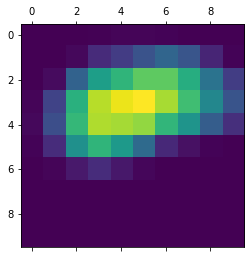

In [69]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [70]:
#superimpose the heatmap on original picture
import matplotlib.cm as cm

#load original image
img = keras.utils.load_img(img_path)                            
img = keras.utils.img_to_array(img) 
#rescale the heatmap to range 0 - 255
heatmap = np.uint8(255 * heatmap)                               

#use jet colormap to recolorize the heatmap
jet = cm.get_cmap("jet")                                       
jet_colors = jet(np.arange(256))[:, :3]                         
jet_heatmap = jet_colors[heatmap]                               

#Create image that contains the recolorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)             
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  
jet_heatmap = keras.utils.img_to_array(jet_heatmap)             

#Superimpose the heatmap over the original image with the heatmap at 40%opacity
superimposed_img = jet_heatmap * 0.4 + img                      
superimposed_img = keras.utils.array_to_img(superimposed_img)   
 
#Save
save_path = "elephant_cam.jpg"                                  
superimposed_img.save(save_path)